# Шаблон для проекта по A/B - тестам.

In [55]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from scipy.stats import mannwhitneyu, ks_2samp, probplot, norm, ttest_ind, cramervonmises_2samp
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.sandbox.stats.multicomp import multipletests
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### `chat_id ` из Телеграма:

In [ ]:
chat_id = 307311223

------------------

##  <ins>Задание 1.</ins>

### 0. Запосить у бота в Телеграме условие командой `/get_project1_desc`.

**Контекст**

Мы считаем, что наш продукт достаточно дорогой для клиента.
У нас есть гипотеза, что уменьшение цены продукта
позволит повысить частоту продаж
и суммарно увеличит доходность продукта.

**Тест**

Мы проводим тест,
в рамках которого контролем является
продажа продукта со старой ценой,
а тестом - продажа продукта с новой ценой.
Целью этого теста
является проверка гипотезы роста доходности
нашего продукта из-за уменьшения тарифа.

**Статистические вводные**

Уровень значимости 5%.
Мы хотели бы различать 5%-ное
изменение целевой метрики
с вероятностью 80%.

### 1. Необходимо выбрать метрику и привести аргументацию.

**Целевая метрика**

Так как в конечном итоге главной целью является увеличение прибыли, в качестве целевой метрики можно выбрать NPV групп. Тогда основная и альтернативные гипотезы будут такими: 

H0: Среднее значение NPV в тестовой и контрольной группах не различается

H1:Среднее значение NPV в тестовой группе (m0) больше, чем среднее значение NPV в контрольной группе(m) (m < m0)

**Контрольная метрика**

Во время тестирования важно следить за тем, чтобы в тестовой группе не упала конверсия, поэтому примем за контрольную метрику конверсию из заявки в продажу. 

**Прокси метрика**

- кумулятивное NPV 
- кумулятивное среднее NPV 

Эти метрики сонаправлены с целевой и созревают быстрее – их можно отслеживать в динамике

### 2. Альтернатива в критерии.

Мы проверяем одностороннюю левостороннюю альтернативу. 

### 3.1. Каков размер выборки? Привести аргументацию и написать как получилось то или иное число.

In [74]:
data = pd.read_csv('hist_telesales.csv')
data.head()

,ID,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
0,0,1,0,90,0,-90
1,1,0,0,5,0,-5
2,2,0,0,68,0,-68
3,3,1,0,22,0,-22
4,4,1,0,22,0,-22


<AxesSubplot:>

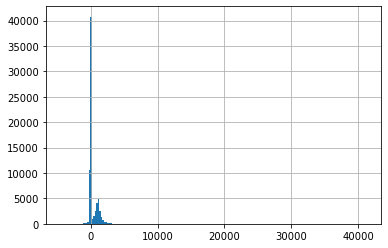

In [75]:
data['NPV'].hist(bins = 200)

Размер выборки можно вычислить по следующей формуле: 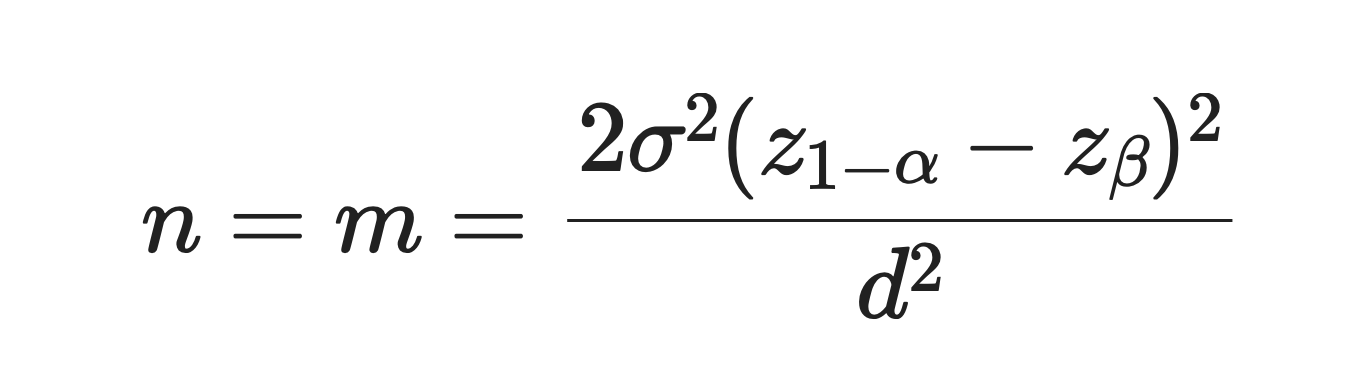

Вычислим дисперсию и среднее на исторических данных: 

In [76]:
alpha = 0.05
beta = 0.2
variance = data['NPV'].var()
d = data['NPV'].mean() * alpha

Тогда минимальный размер выборки: 

In [77]:
size = (2 * variance * (norm.ppf(1.0 - alpha) - norm.ppf(beta)) ** 2) / (d ** 2)
round(size)

28672

### 3.2. Необходимо запросить у бота в Телеграме выборку полученного размера командой `/get_project1_sample {размер выборки}` и вписать <ins>код выборки</ins>:

In [78]:
sample_id = 33280

In [98]:
control = pd.read_csv('Контроль.csv')
test = pd.read_csv('Тест.csv')

### 4. Принятие решения. Расписать подробно с аргументами.

In [99]:
control.head()

,ID,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
0,0,0,0,14,0,-14
1,1,0,0,301,0,-301
2,2,1,0,180,0,-180
3,3,0,0,47,0,-47
4,4,0,0,8,0,-8


Cначала посмотрим изменение метрики в динамике на тесте и контроле. 

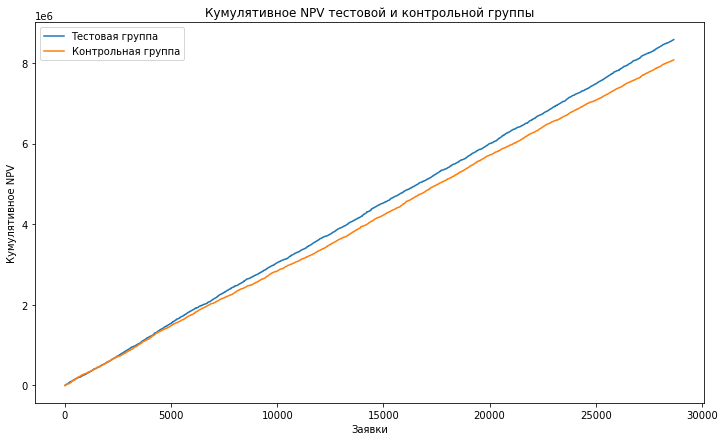

In [100]:
plt.figure(figsize=(12, 7))

plt.plot(test['ID'], test['NPV'].cumsum(), label='Тестовая группа')
plt.plot(control['ID'], control['NPV'].cumsum(), label='Контрольная группа')
plt.title('Кумулятивное NPV тестовой и контрольной группы')
plt.ylabel('Кумулятивное NPV')
plt.xlabel('Заявки')
plt.legend()
plt.show()

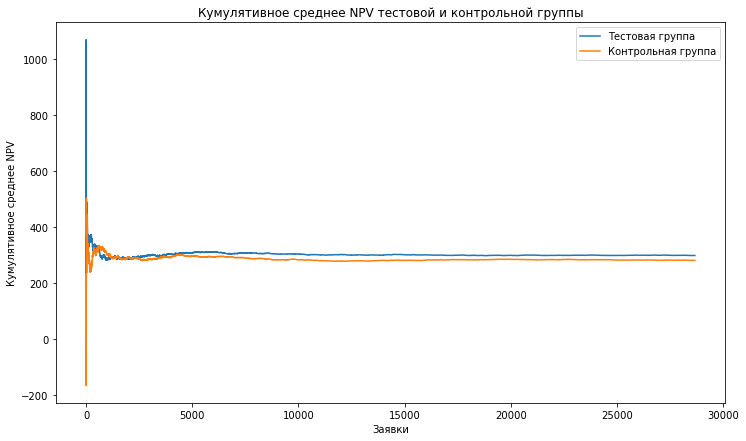

In [101]:
plt.figure(figsize=(12, 7))

plt.plot(test['ID'], test['NPV'].expanding(min_periods=1).mean(), label='Тестовая группа')
plt.plot(control['ID'], control['NPV'].expanding(min_periods=1).mean(), label='Контрольная группа')
plt.title('Кумулятивное среднее NPV тестовой и контрольной группы')
plt.ylabel('Кумулятивное среднее NPV')
plt.xlabel('Заявки')
plt.legend()
plt.show()

Как мы видим, тестовая группа со временем демонстрировала все более высокий уровень кумулятивного NPV и сохраняла более высокое кумулятивное среднее NPV на протяжении большей части теста. 

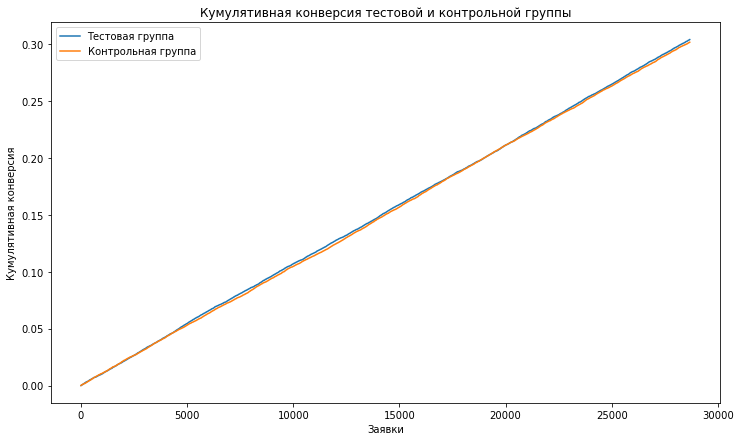

In [102]:
control['cum_sale_flag'] = control['Флаг продажи'].cumsum()
test['cum_sale_flag'] = test['Флаг продажи'].cumsum()

plt.figure(figsize=(12, 7))

plt.plot(test['ID'], test['cum_sale_flag'] / len(control), label='Тестовая группа')
plt.plot(control['ID'], control['cum_sale_flag'] / len(control), label='Контрольная группа')
plt.title('Кумулятивная конверсия тестовой и контрольной группы')
plt.ylabel('Кумулятивная конверсия')
plt.xlabel('Заявки')
plt.legend()
plt.show()

Hа протяжении всего тестирования конверсия теста была на том же уровне, что и контроля, то есть метрику мы не уронили – это хорошо. 

Осталось посмотреть на распределение целевой метрики: 

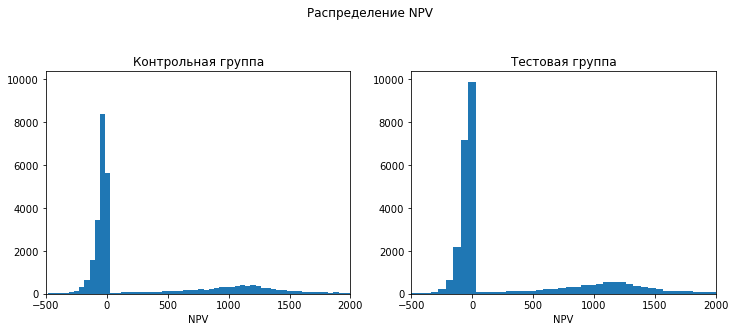

In [103]:
fig = plt.figure(figsize=(12, 9))

ax1 = plt.subplot(2, 2, 1)
ax1.hist(control['NPV'], bins=300)
plt.xlim(-500, 2000)
plt.title('Контрольная группа')
plt.xlabel('NPV')

ax2 = plt.subplot(2, 2, 2, sharey = ax1)
ax2.hist(test['NPV'], bins=300)
plt.xlim(-500, 2000)
plt.xlabel('NPV')

fig.suptitle('Распределение NPV')
plt.title('Тестовая группа')
plt.show()

Посмотрим, можно ли отвергнуть нулевую гипотезу:

In [104]:
stat, p_value = ttest_ind(test['NPV'], control['NPV'], alternative='greater')

percent = round(test['NPV'].mean()/control['NPV'].mean()-1, 3)

print(f'Процентное различие между средними равно {percent}')
print(f'p-value: {p_value}')

if p_value < 0.05:
    print('Отвергаем нулевую гипотезу: между выборками есть значимая разница')
else:
    print('Не отвергаем нулевую гипотезу, средние можно считать равными')

Процентное различие между средними равно 0.062
p-value: 0.0007549281357076117
Отвергаем нулевую гипотезу: между выборками есть значимая разница


Мы отвергли нулевую гипотезу. То есть можно считать, что доходность нашего продукта действительно растет благодвря уменьшению тарифа

##  <ins>Задание 2.</ins>

### 0. Запосить у бота в Телеграме условие командой `/get_project2_desc`.

**Контекст**

Мы провели конкурентный анализ
и поняли,
что тариф нашей услуги достаточно низкий.
Мы хотим попробовать повысить тариф,
и надеемся,
что снижение конверсии в подключение услуги
компенсируется ростом дохода с этой услуги.

**Тест**

Мы проводим тест,
в рамках которого мы разбиваем весь поток
на две части рановероятно,
где одной части (контролю) 
мы будем предлагать старый тариф услуги,
а второй части (тесту) - новый тариф услуги.
Целью этого теста
является увеличение доходности услуги.


**Статистические вводные**

Проверка однородности выбранного параметра
осуществяется с уровнем значимости 2%.

Уровень значимости 5%.
Мы хотели бы различать 8%-ное
изменение целевой метрики
с вероятностью 90%.

In [85]:
data = pd.read_csv('hist_credit_card.csv')
data.head()

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
0,0,19,21620.835463,0.138061,0,102,0,0,-102
1,1,27,24897.990863,0.035508,1,409,11686,1754,13031
2,2,50,23989.526947,0.098793,0,16,0,0,-16
3,3,18,38442.409756,0.365661,1,788,13738,1578,14528
4,4,24,21291.521612,0.036909,1,1048,6594,2213,7759


### 1. Необходимо выбрать метрику и привести аргументацию.

**Целевая метрика**

Так как в конечном итоге главной целью является увеличение прибыли, в качестве целевой метрики можно выбрать PV групп. Тогда основная и альтернативные гипотезы будут такими: 

H0: Среднее значение PV в тестовой и контрольной группах не различается

H1:Среднее значение PV в тестовой группе (m0) больше, чем среднее значение PV в контрольной группе(m) (m < m0)

**Контрольная метрика**

Во время тестирования важно следить за тем, чтобы мы не потеряли много клиентов (то есть чтобы конверсия в утилизацию счета не увеличилась).

- конверсия в утилизацию счета.

**Прокси метрика**

- кумулятивное PV 
- кумулятивное среднее PV 

Эти метрики сонаправлены с целевой и созревают быстрее – их можно отслеживать в динамике

### 2. Альтернатива в критерии.

Мы проверяем одностороннюю левостороннюю альтернативу. 

### 3. Нужно выбрать параметр(-ы), влияющий(-ие) на целевую метрику. Привести аргументацию.

Параметр будет служить для проверки однородности. Посмотрим на корреляцию: 

In [86]:
data.corr()[['PV услуги']].sort_values(by='PV услуги')

,PV услуги
Вероятность банкротства,-0.139128
ID,-0.005220
Доход клиента,-0.001937
Возраст,0.006117
PV КК,0.128742
NPV,0.183529
Расходы,0.294538
Флаг утилизации счёта,0.646524
PV услуги,1.000000


<AxesSubplot:>

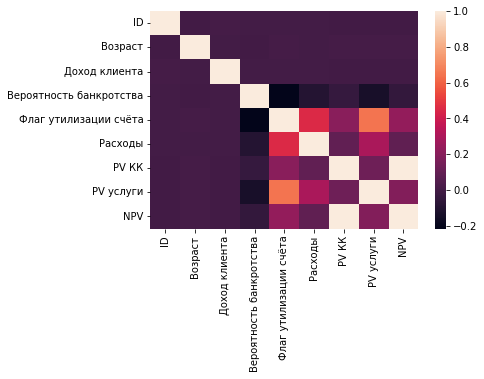

In [87]:
sns.heatmap(data.corr())

Наибольшую корреляцию по модулю c метрикой имеют данные о вероятности банкротства. Эту метрики и выберем для однородности выборок.

### 4.1. Каков размер выборки? Привести аргументацию и написать как получилось то или иное число.

Размер выборки можно сосчитать по той же формуле, что и в разделе 1: 

Вычислим дисперсию и среднее на исторических данных: 

In [88]:
alpha = 0.05
beta = 0.1
gamma = 0.08
variance = data['PV услуги'].var()
d = data['PV услуги'].mean() * gamma

Тогда минимальный размер выборки: 

In [89]:
size = (2 * variance * (norm.ppf(1.0 - alpha) - norm.ppf(beta)) ** 2) / (d ** 2)
round(size)

2232

### 4.2. Необходимо запросить у бота в Телеграме выборку полученного размера командой `/get_project2_sample {размер выборки}` и вписать <ins>код выборки</ins>:

In [90]:
sample_id = 36274

In [108]:
control = pd.read_csv('Контроль (2).csv')
test = pd.read_csv('Тест (2).csv')

In [109]:
test.head()

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
0,0,18,24711.000455,0.314004,0,24,0,0,-24
1,1,71,21604.667947,0.147364,1,1065,6400,2835,8170
2,2,47,23779.104268,0.312878,0,77,0,0,-77
3,3,56,28405.126337,0.085241,1,433,11208,3562,14337
4,4,65,23884.676108,0.044871,1,929,5399,1444,5914


### 5. Проверка на однородность, применение критерия. Принятие решения. Расписать подробно с аргументами.

Сначала нужно проверить выборки на однородность

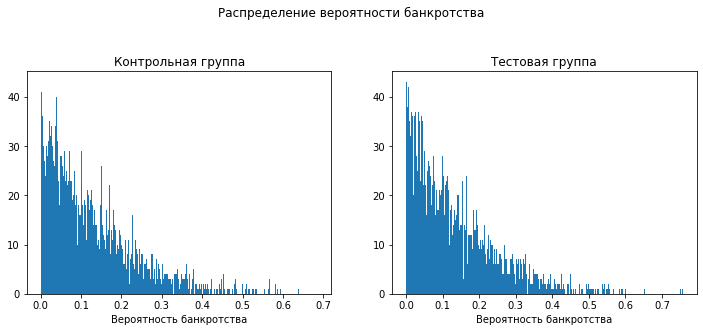

In [110]:
fig = plt.figure(figsize=(12, 9))

ax1 = plt.subplot(2, 2, 1)
ax1.hist(control['Вероятность банкротства'], bins=300)
plt.title('Контрольная группа')
plt.xlabel('Вероятность банкротства')

ax2 = plt.subplot(2, 2, 2, sharey = ax1)
ax2.hist(test['Вероятность банкротства'], bins=300)
plt.xlabel('Вероятность банкротства')

fig.suptitle('Распределение вероятности банкротства')
plt.title('Тестовая группа')
plt.show()

Чтобы проверить однородность, достаточно критерия Колмогорова-Смирнова. 

In [111]:
p_value = ks_2samp(test['Вероятность банкротства'], control['Вероятность банкротства']).pvalue

print(f'p-value: {p_value}')

if p_value < 0.02:
    print('Отвергаем нулевую гипотезу: выборки из разных распределений')
else:
    print('Принимаем нулевую гипотезу: выборки имеют одинаковое распределение')

p-value: 0.19587982501067822
Принимаем нулевую гипотезу: выборки имеют одинаковое распределение


Попробуем проверить по Леману-Розенблатту. 

In [112]:
p_value = cramervonmises_2samp(test['Вероятность банкротства'], control['Вероятность банкротства']).pvalue

print(f'p-value: {p_value}')

if p_value < 0.02:
    print('Отвергаем нулевую гипотезу: выборки из разных распределений')
else:
    print('Принимаем нулевую гипотезу: выборки имеют одинаковое распределение')

p-value: 0.24653585333248473
Принимаем нулевую гипотезу: выборки имеют одинаковое распределение


И по Манну-Уитни:

In [113]:
p_value = mannwhitneyu(test['Вероятность банкротства'], control['Вероятность банкротства']).pvalue

print(f'p-value: {p_value}')

if p_value < 0.02:
    print('Отвергаем нулевую гипотезу: выборки из разных распределений')
else:
    print('Принимаем нулевую гипотезу: выборки имеют одинаковое распределение')

p-value: 0.25653961878026266
Принимаем нулевую гипотезу: выборки имеют одинаковое распределение


У нас нет оснований, чтобы отклонить нулевую гипотезу. То есть выборки имеют одинаковое распределение. Попробуем применить критерий и посмотреть на то, насколько метрики менялись в контрольной и тестовой группах.

Cначала посмотрим изменение метрики в динамике на тесте и контроле. 

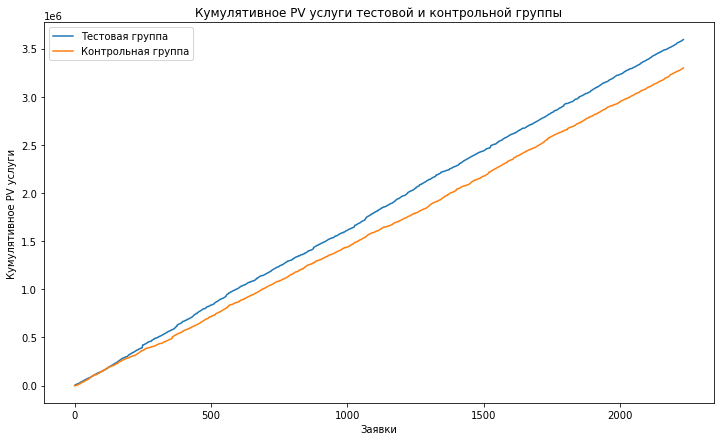

In [114]:
plt.figure(figsize=(12, 7))

plt.plot(test['ID'], test['PV услуги'].cumsum(), label='Тестовая группа')
plt.plot(control['ID'], control['PV услуги'].cumsum(), label='Контрольная группа')
plt.title('Кумулятивное PV услуги тестовой и контрольной группы')
plt.ylabel('Кумулятивное PV услуги')
plt.xlabel('Заявки')
plt.legend()
plt.show()

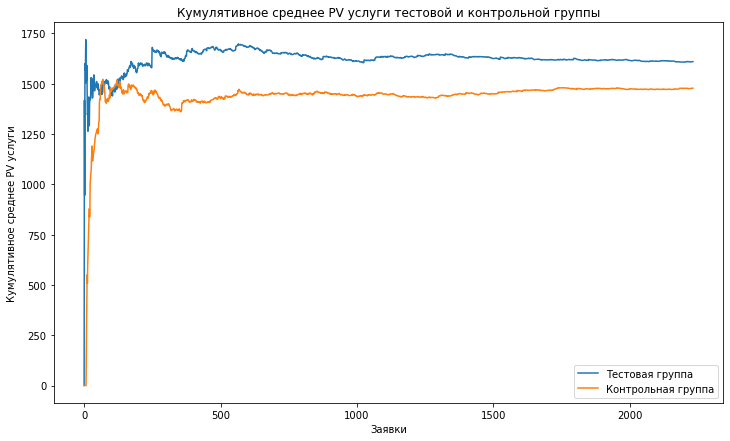

In [115]:
plt.figure(figsize=(12, 7))

plt.plot(test['ID'], test['PV услуги'].expanding(min_periods=1).mean(), label='Тестовая группа')
plt.plot(control['ID'], control['PV услуги'].expanding(min_periods=1).mean(), label='Контрольная группа')
plt.title('Кумулятивное среднее PV услуги тестовой и контрольной группы')
plt.ylabel('Кумулятивное среднее PV услуги')
plt.xlabel('Заявки')
plt.legend()
plt.show()

Как мы видим, тестовая группа со временем демонстрировала все более высокий уровень кумулятивного PV услуги и сохраняла более высокое кумулятивное среднее PV услуги на протяжении большей части теста. 

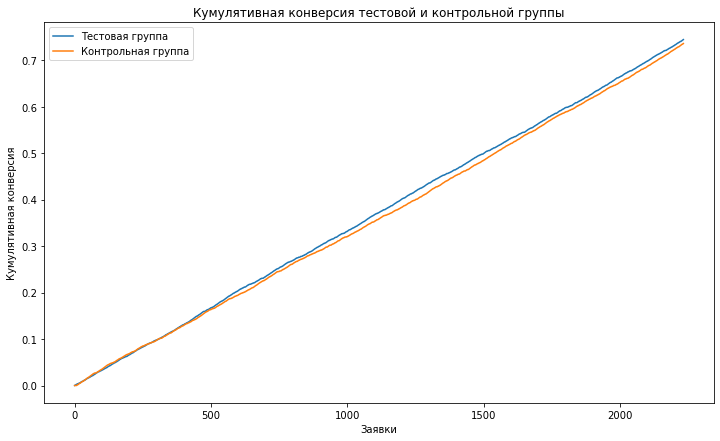

In [117]:
control['cum_sale_flag'] = control['Флаг утилизации счёта'].cumsum()
test['cum_sale_flag'] = test['Флаг утилизации счёта'].cumsum()

plt.figure(figsize=(12, 7))

plt.plot(test['ID'], test['cum_sale_flag'] / len(control), label='Тестовая группа')
plt.plot(control['ID'], control['cum_sale_flag'] / len(control), label='Контрольная группа')
plt.title('Кумулятивная конверсия тестовой и контрольной группы')
plt.ylabel('Кумулятивная конверсия')
plt.xlabel('Заявки')
plt.legend()
plt.show()

Hа протяжении всего тестирования конверсия теста была примерно на том же уровне, что и контроля, то есть метрику мы не уронили – это хорошо. 

Осталось посмотреть на распределение целевой метрики: 

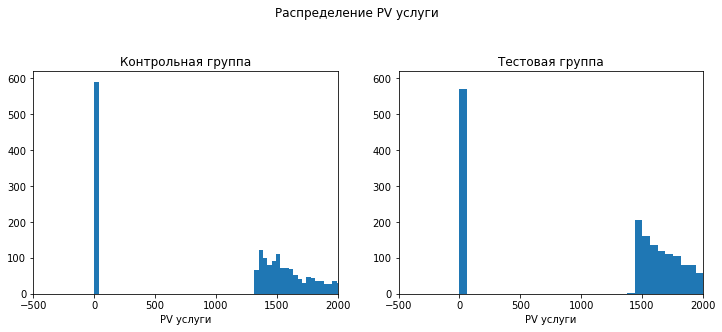

In [118]:
fig = plt.figure(figsize=(12, 9))

ax1 = plt.subplot(2, 2, 1)
ax1.hist(control['PV услуги'], bins=400)
plt.xlim(-500, 2000)
plt.title('Контрольная группа')
plt.xlabel('PV услуги')

ax2 = plt.subplot(2, 2, 2, sharey = ax1)
ax2.hist(test['PV услуги'], bins=400)
plt.xlim(-500, 2000)
plt.xlabel('PV услуги')

fig.suptitle('Распределение PV услуги')
plt.title('Тестовая группа')
plt.show()

Посмотрим, можно ли отвергнуть нулевую гипотезу:

In [119]:
stat, p_value = ttest_ind(test['PV услуги'], control['PV услуги'], alternative='greater')

percent = round(test['PV услуги'].mean()/control['PV услуги'].mean()-1, 3)

print(f'Процентное различие между средними равно {percent}')
print(f'p-value: {p_value}')

if p_value < 0.05:
    print('Отвергаем нулевую гипотезу: между выборками есть значимая разница')
else:
    print('Не отвергаем нулевую гипотезу, средние можно считать равными')

Процентное различие между средними равно 0.089
p-value: 0.0005838507697635073
Отвергаем нулевую гипотезу: между выборками есть значимая разница


Мы отвергли нулевую гипотезу. То есть можно считать, что доходность нашего продукта действительно растет благодаря поднятию цен. 